# Train and test DNN models for parking space prediction

In [1]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras

import matplotlib as mpl

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

## General functions

In [2]:
def read_clean_subflows_fn(critera):
    subflows= {}
    for c in critera:
        df = pd.read_csv(os.path.join('data', 'INE_subflows','flow_criterion_{}_clean.csv'.format(c)),
                       parse_dates=[0], index_col=0)
        subflows[c] = df
    return subflows

## Read zones 1 parking data (target variable)

In [3]:
zone1_df = pd.read_csv(os.path.join('data', 'parkings_JULIO', 'zone1.csv'), sep=';', parse_dates=['recvTime'], index_col='recvTime')

In [4]:
zone1_df.head()

,free
recvTime,
2020-07-13 10:00:00,167.363636
2020-07-13 11:00:00,246.157895
2020-07-13 12:00:00,351.465909
2020-07-13 13:00:00,404.080000
2020-07-13 14:00:00,362.413238


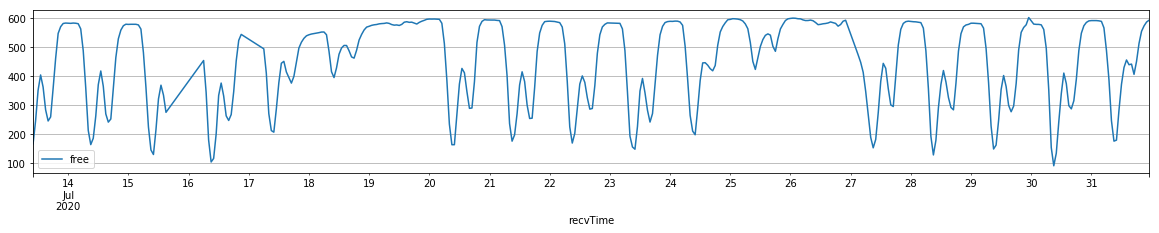

In [5]:
zone1_df.plot(figsize=(20,3),grid=True);

In [6]:
target_days = zone1_df.index

## Read subflows

In [7]:
target_criteria = range(6,11)

In [8]:
mob_flows = read_clean_subflows_fn(target_criteria)

## Format data

In [9]:
n_steps = 12
T_ = 1

In [10]:
#input: flow(t), flow(t-1), ..,flow(t-prev_hours). output: parking(t+T)
def generate_univariate_time_series_fn(zone_parking, subflow, prev_hours, T=1):
    series = []
    for i in range(0,subflow.shape[0]-prev_hours-T):
        mob_values = subflow[i:i+prev_hours].values
        parking_value = zone_parking.iloc[prev_hours + i +T -1]
        s = np.append(mob_values,parking_value).reshape(-1,prev_hours+1)
        series.append(s)
    series= np.array(series)
    series = series.reshape(series.shape[0],prev_hours+1,1)
    return series

In [11]:
def generate_time_series_for_rnn_fn(zone_parking, subflow, prev_hours, T=1):
    X= []
    Y= []
    for i in range(0,subflow.shape[0]-prev_hours-T):
        mob_values = subflow[i:i+prev_hours].values
        X.append(mob_values)
        parking_values = zone_parking.iloc[i+T:i+T+prev_hours].values
        Y.append(parking_values)
    X= np.array(X)
    X = X.reshape(X.shape[0],prev_hours,1)
    
    Y= np.array(Y)
    Y = Y.reshape(Y.shape[0],prev_hours,1)
    
    return X,Y

### Scale data

In [12]:
scaler_flow =  StandardScaler()
flow_scaled = scaler_flow.fit_transform(mob_flows[9].loc[target_days].values)
flow_scaled_df = pd.DataFrame(flow_scaled)
flow_scaled_df.head()

,0
0,1.050581
1,0.537342
2,0.377285
3,0.498533
4,1.536396


In [13]:
scaler_parking =  StandardScaler()
zone_scaled =scaler_parking.fit_transform(zone1_df.values)
parking_scaled_df = pd.DataFrame(zone_scaled)
parking_scaled_df.head()

,0
0,-2.046244
1,-1.477782
2,-0.718037
3,-0.338452
4,-0.639057


### Generate time series samples

In [14]:
ts = generate_univariate_time_series_fn(parking_scaled_df, flow_scaled_df, n_steps, T_)

In [15]:
ts.shape

(433, 13, 1)

In [16]:
n_series = ts.shape[0]

## Split training-test

In [17]:
training_rate = 0.9

In [18]:
n_series_training = round(n_series * training_rate)

In [19]:
X_train, y_train = ts[:n_series_training,:n_steps], ts[:n_series_training, -1]
X_valid, y_valid = ts[n_series_training:,:n_steps], ts[n_series_training:, -1]

In [20]:
X_train.shape, y_train.shape

((390, 12, 1), (390, 1))

In [21]:
X_valid.shape, y_valid.shape

((43, 12, 1), (43, 1))

## Test DNN models

In [22]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    #plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [23]:
def compute_metrics_fn(y_valid, y_hat, scaler):
    ## actual train and test values
    y_hat_resc = scaler_parking.inverse_transform(y_hat)
    y_valid_resc = scaler_parking.inverse_transform(y_valid)

    mae_ = mean_absolute_error(y_valid_resc, y_hat_resc)
    mse_ = mean_squared_error(y_valid_resc, y_hat_resc)
    rmse_ = mean_squared_error(y_valid_resc, y_hat_resc, squared = False)
    
    return mae_, mse_, rmse_

In [24]:
def plot_prediction_vs_groundtruth_fn(y_valid, y_hat):
    y_hat_resc = scaler_parking.inverse_transform( y_hat[:,-1].reshape(-1,))
    y_valid_resc = scaler_parking.inverse_transform(y_valid[:,-1].reshape(-1,))
    plt.plot(np.arange(len(y_hat_resc)), y_hat_resc, "b.-", label="y_hat")
    plt.plot(np.arange(len(y_valid_resc)), y_valid_resc, "r.-", label="y_true")
    plt.legend(fontsize=14)
    plt.xlabel("Timestamp")
    plt.ylabel("Free places")
    plt.grid(True)

### MLP - benchmark

In [25]:
import tensorflow as tf
from tensorflow import keras

In [26]:
np.random.seed(42)
tf.random.set_seed(42)

model_mlp = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[n_steps, 1]),
    keras.layers.Dense(1)
])

model_mlp.compile(loss="mse", optimizer="adam")
history = model_mlp.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid))

Epoch 1/100
13/13 [==============================] - 1s 46ms/step - loss: 1.2170 - val_loss: 1.3824
Epoch 2/100
13/13 [==============================] - 0s 4ms/step - loss: 1.0724 - val_loss: 1.2606
Epoch 3/100
13/13 [==============================] - 0s 5ms/step - loss: 0.9997 - val_loss: 1.1596
Epoch 4/100
13/13 [==============================] - 0s 4ms/step - loss: 0.9920 - val_loss: 1.0710
Epoch 5/100
13/13 [==============================] - 0s 4ms/step - loss: 0.9681 - val_loss: 0.9869
Epoch 6/100
13/13 [==============================] - 0s 4ms/step - loss: 0.9015 - val_loss: 0.9232
Epoch 7/100
13/13 [==============================] - 0s 5ms/step - loss: 0.8938 - val_loss: 0.8644
Epoch 8/100
13/13 [==============================] - 0s 4ms/step - loss: 0.8750 - val_loss: 0.8215
Epoch 9/100
13/13 [==============================] - 0s 4ms/step - loss: 0.7980 - val_loss: 0.7802
Epoch 10/100
13/13 [==============================] - 0s 4ms/step - loss: 0.8626 - val_loss: 0.7450
Epoch 11

Epoch 83/100
13/13 [==============================] - 0s 4ms/step - loss: 0.5894 - val_loss: 0.3968
Epoch 84/100
13/13 [==============================] - 0s 4ms/step - loss: 0.5200 - val_loss: 0.4005
Epoch 85/100
13/13 [==============================] - 0s 4ms/step - loss: 0.5794 - val_loss: 0.3992
Epoch 86/100
13/13 [==============================] - 0s 4ms/step - loss: 0.5829 - val_loss: 0.4014
Epoch 87/100
13/13 [==============================] - 0s 3ms/step - loss: 0.5614 - val_loss: 0.4073
Epoch 88/100
13/13 [==============================] - 0s 4ms/step - loss: 0.5548 - val_loss: 0.4075
Epoch 89/100
13/13 [==============================] - 0s 3ms/step - loss: 0.5212 - val_loss: 0.4045
Epoch 90/100
13/13 [==============================] - 0s 4ms/step - loss: 0.5353 - val_loss: 0.3942
Epoch 91/100
13/13 [==============================] - 0s 5ms/step - loss: 0.5413 - val_loss: 0.3903
Epoch 92/100
13/13 [==============================] - 0s 3ms/step - loss: 0.5186 - val_loss: 0.3853


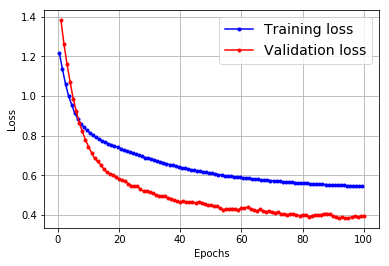

In [27]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [28]:
y_hat = model_mlp.predict(X_valid)

#### Get metrics

In [29]:
mae_, mse_, rmse_ = compute_metrics_fn(y_valid, y_hat, scaler_parking)

print('MAE: {:.3f}, MSE: {:.3f}, RMSE: {:.3f}'.format(mae_, mse_, rmse_))

MAE: 73.932, MSE: 7553.531, RMSE: 86.911


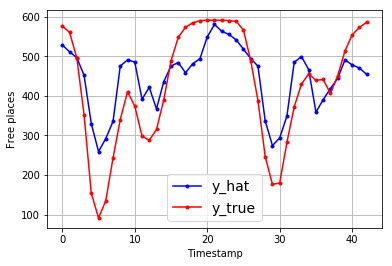

In [30]:
plot_prediction_vs_groundtruth_fn(y_valid, y_hat)

###  GRU model

In [31]:
X, Y = generate_time_series_for_rnn_fn(parking_scaled_df, flow_scaled_df, 12, T=1)

In [32]:
n_train_samples = round(X.shape[0] * training_rate)
X_train = X[:n_train_samples]
y_train = Y[:n_train_samples]

X_valid = X[n_train_samples:]
y_valid = Y[n_train_samples:]

In [33]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((390, 12, 1), (390, 12, 1), (43, 12, 1), (43, 12, 1))

In [34]:
np.random.seed(42)
tf.random.set_seed(42)

model_gru = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True,  input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10)),
    keras.layers.Dense(1)
])

model_gru.compile(loss="mse", optimizer="adam")
history = model_gru.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid))

Epoch 1/50
13/13 [==============================] - 4s 86ms/step - loss: 0.9945 - val_loss: 1.1563
Epoch 2/50
13/13 [==============================] - 0s 13ms/step - loss: 0.9359 - val_loss: 1.0627
Epoch 3/50
13/13 [==============================] - 0s 13ms/step - loss: 0.8595 - val_loss: 0.9398
Epoch 4/50
13/13 [==============================] - 0s 11ms/step - loss: 0.8019 - val_loss: 0.7779
Epoch 5/50
13/13 [==============================] - 0s 11ms/step - loss: 0.7292 - val_loss: 0.6826
Epoch 6/50
13/13 [==============================] - 0s 13ms/step - loss: 0.7100 - val_loss: 0.6385
Epoch 7/50
13/13 [==============================] - 0s 12ms/step - loss: 0.6754 - val_loss: 0.6101
Epoch 8/50
13/13 [==============================] - 0s 11ms/step - loss: 0.6330 - val_loss: 0.5584
Epoch 9/50
13/13 [==============================] - 0s 11ms/step - loss: 0.5878 - val_loss: 0.5062
Epoch 10/50
13/13 [==============================] - 0s 12ms/step - loss: 0.5792 - val_loss: 0.4902
Epoch 11/

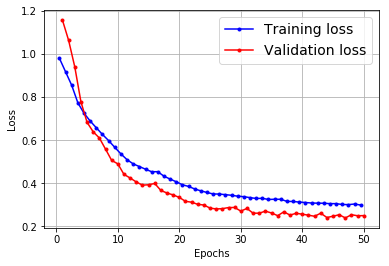

In [35]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [36]:
y_hat = model_gru.predict(X_valid)

In [37]:
print()
mae_, mse_, rmse_ = compute_metrics_fn(y_valid[:,-1].reshape(-1,), y_hat[:,-1].reshape(-1,), scaler_parking)

print('MAE: {:.3f}, MSE: {:.3f}, RMSE: {:.3f}'.format(mae_, mse_, rmse_))


MAE: 32.937, MSE: 2030.887, RMSE: 45.065


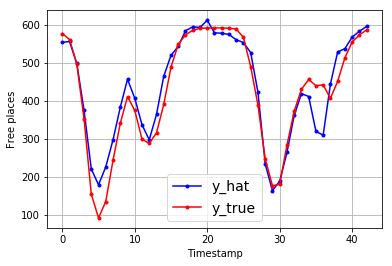

In [38]:
plot_prediction_vs_groundtruth_fn(y_valid, y_hat)

------------------------------------

In [40]:
print("That's all folks!")

That's all folks
